In [23]:
import os
import sys
from collections import OrderedDict

In [24]:
sys.path.append("../..")

In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import spatialpy
spatialpy.__file__

'../../spatialpy/__init__.py'

In [27]:
import matplotlib.pyplot as plt
import numpy

# Global Constants
MAX_X_DIM = 5.0
MIN_X_DIM = -5.0
TOL = 1e-9

In [28]:
class Edge1(spatialpy.Geometry):
    def inside(self, x, on_boundary):
        return abs(x[0] - MAX_X_DIM) < 0.05
class Edge2(spatialpy.Geometry):
    def inside(self, x, on_boundary):
        return abs(x[0] - MIN_X_DIM) < 0.05
class Middle(spatialpy.Geometry):
    def inside(self, x, on_boundary):
        return abs(x[0] - MIN_X_DIM) >= 0.05

In [29]:
class cylinderDemo3D(spatialpy.Model):
    def __init__(self, model_name="cylinder_demo3d"):
        spatialpy.Model.__init__(self, model_name)

        self.timestep_size = 1
        
        # System constants
        D_const = 0.1

        # Define Species
        A = spatialpy.Species(name="A", diffusion_constant=D_const)
        B = spatialpy.Species(name="B", diffusion_constant=D_const)
        self.add_species([A, B])

        # Define Geometry
        self.mesh = spatialpy.Mesh.read_xml_mesh('cylinder.xml')

        # Define Types
        self.set_type(Middle(), 1)
        self.set_type(Edge1(), 2)
        self.set_type(Edge2(), 3)
        
        # Restrict the movement of Chemical Species
        self.restrict(A,[1,2])
        self.restrict(B,[1,3])

        vol = self.mesh.get_vol()
        print("vol",vol)
        type = self.mesh.type
        left = numpy.sum(vol[type == 2])
        right = numpy.sum(vol[type == 3])
        print("left "+str(left)+" right "+str(right))
        
        k_react = spatialpy.Parameter(name="k_react", expression=1.0)
        k_creat1 = spatialpy.Parameter(name="k_creat1", 
                                     expression=100/left)
        k_creat2 = spatialpy.Parameter(name="k_creat2", 
                                     expression=100/right)
        self.add_parameter([k_react, k_creat1,k_creat2])


        # Define Reactions
        R1 = spatialpy.Reaction(reactants=None, products={A:1}, 
                                rate=k_creat1, restrict_to=2)
        R2 = spatialpy.Reaction(reactants=None, products={B:1}, 
                              rate=k_creat2, restrict_to=3)
        R3 = spatialpy.Reaction(reactants={A:1, B:1}, products=None, 
                              rate=k_react)
        self.add_reaction([R1, R2, R3])

        # Define simulation timespan
        #self.set_timesteps(1, 200)
        self.timespan(range(500))

In [30]:
model = cylinderDemo3D()

vol [0.01513526 0.07034112 0.02382667 ... 0.01674217 0.02120607 0.01969156]
left 0.5092013833059308 right 0.505804729089437


In [31]:
model.listOfReactions

OrderedDict([('rxna0342edc_6aa9_4f24_997a_943c1e1e51f1',
              <spatialpy.Model.Reaction at 0x7fdb283ff130>),
             ('rxn1922b62c_7107_4d6a_827d_ae69740fed5a',
              <spatialpy.Model.Reaction at 0x7fdb283ff6d0>),
             ('rxn91db8258_4ffb_44ef_9142_cc8c94d18d16',
              <spatialpy.Model.Reaction at 0x7fdb283ff3a0>)])

In [32]:
%time result = model.run()

CPU times: user 5.35 s, sys: 7.97 ms, total: 5.36 s
Wall time: 14.1 s


28587.0
30734.0
0.5092013833059308
0.505804729089437


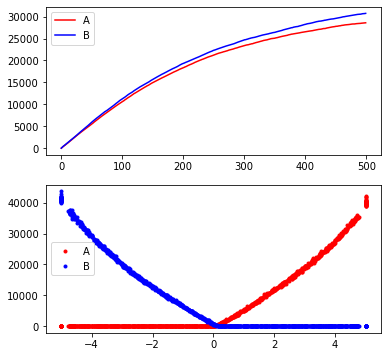

In [33]:
# Plot of the time-average spatial concentration.
x_vals = model.mesh.coordinates()[:, 0]
A_vals = numpy.sum(result.get_species("A", concentration=False), axis=0)
B_vals = numpy.sum(result.get_species("B", concentration=False), axis=0)

A_sum = numpy.sum(result.get_species("A"), axis=1)
B_sum = numpy.sum(result.get_species("B"), axis=1)
print(A_sum[-1])
print(B_sum[-1])
plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
plt.plot(result.get_timespan(),A_sum,'-r',label="A")
plt.plot(result.get_timespan(),B_sum,'-b',label="B")
plt.legend(loc='best')
plt.subplot(2,1,2)

vol = model.mesh.vol
type = model.mesh.type
print(numpy.sum(vol[type == 2]))
print(numpy.sum(vol[type == 3]))


plt.plot(x_vals,A_vals,'.r',x_vals,B_vals,'.b')
plt.legend(['A', 'B'],loc='best')


In [34]:
def plot_step(t_ndx,key='type'):
    pts, data = result.read_step(t_ndx)
    plt.figure(figsize=(15,10) )
    plt.scatter(pts[:,0],pts[:,1],c=data[key])
    plt.axis('equal')
    plt.colorbar()
    plt.title('t={0}'.format(t_ndx))

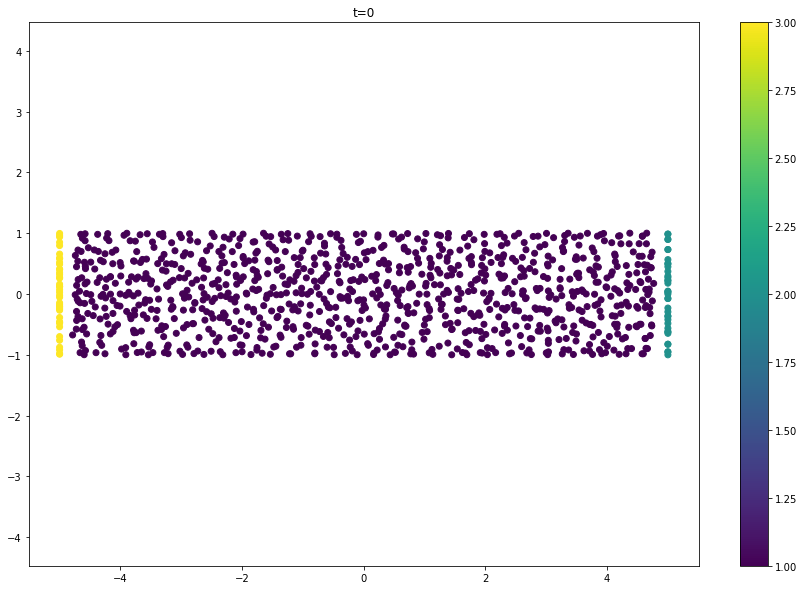

In [35]:
plot_step(0)

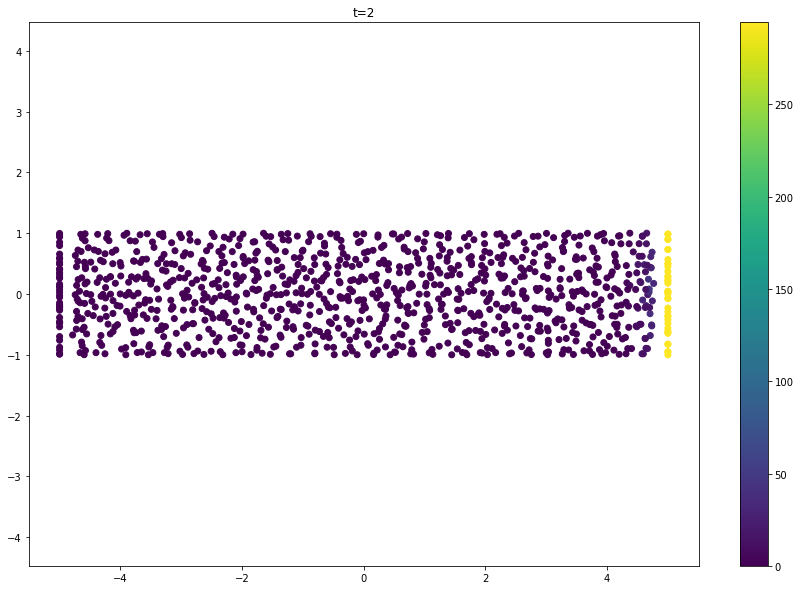

In [36]:
plot_step(2,'C[A]')

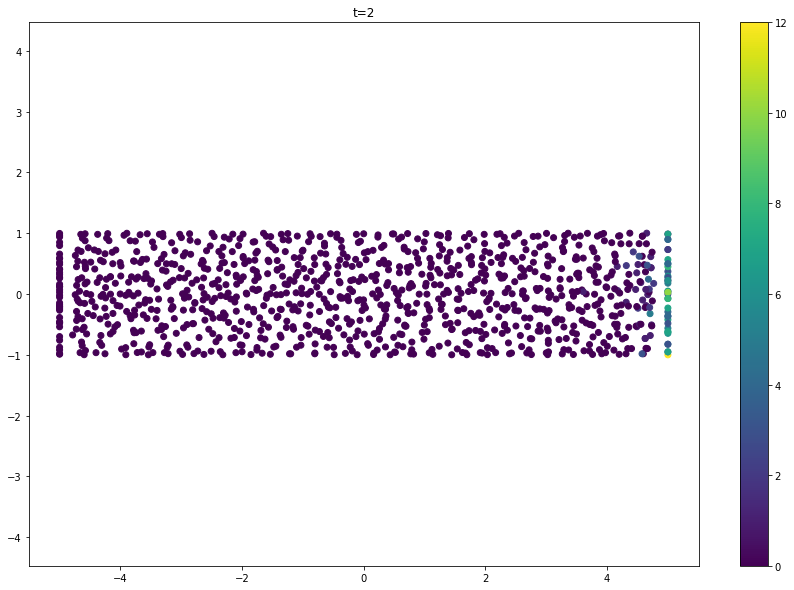

In [37]:
plot_step(2,'D[A]')

In [38]:
# Plot the subdomains
result.plot_property("type", 2)

In [39]:
result.plot_species("A", t_ndx=2, deterministic=True)

In [40]:
result.plot_species("A", t_ndx=2, size=10)

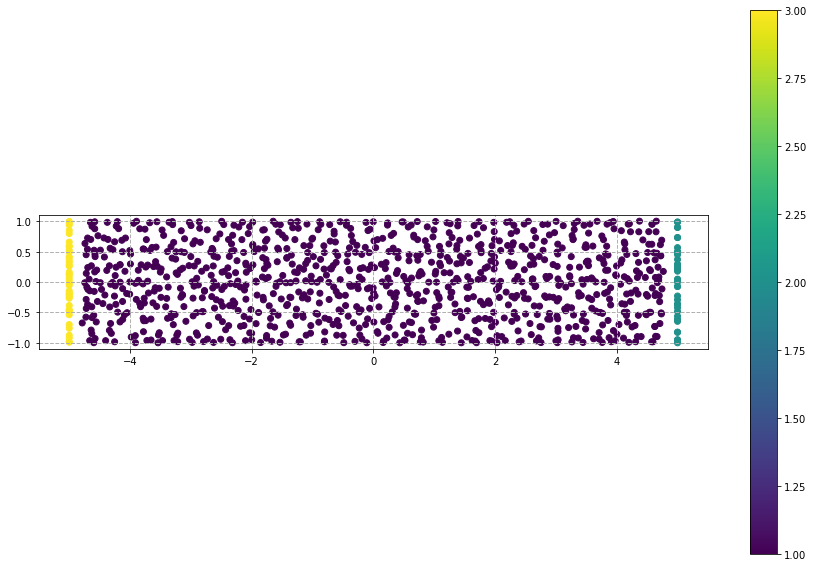

In [41]:
result.plot_property("type", use_matplotlib=True, mpl_width=15, mpl_height=10)

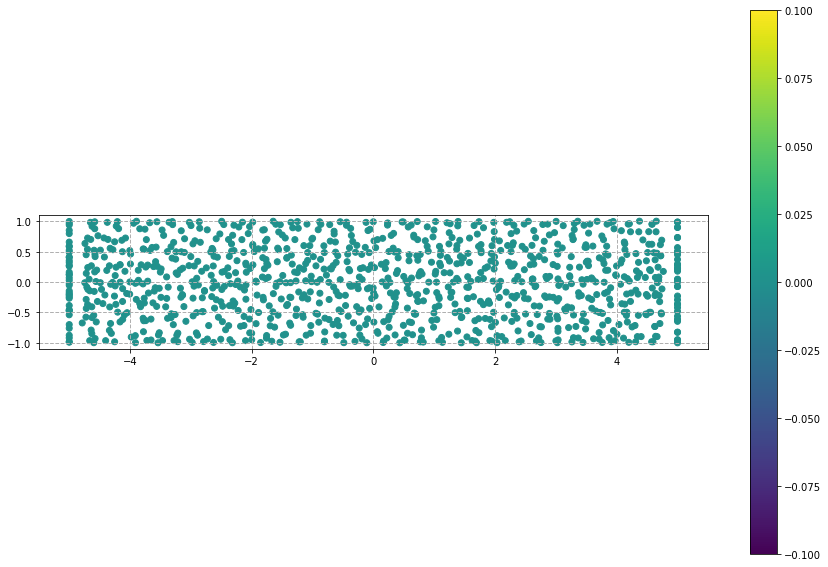

In [42]:
result.plot_species("A", deterministic=True, use_matplotlib=True, mpl_width=15, mpl_height=10)

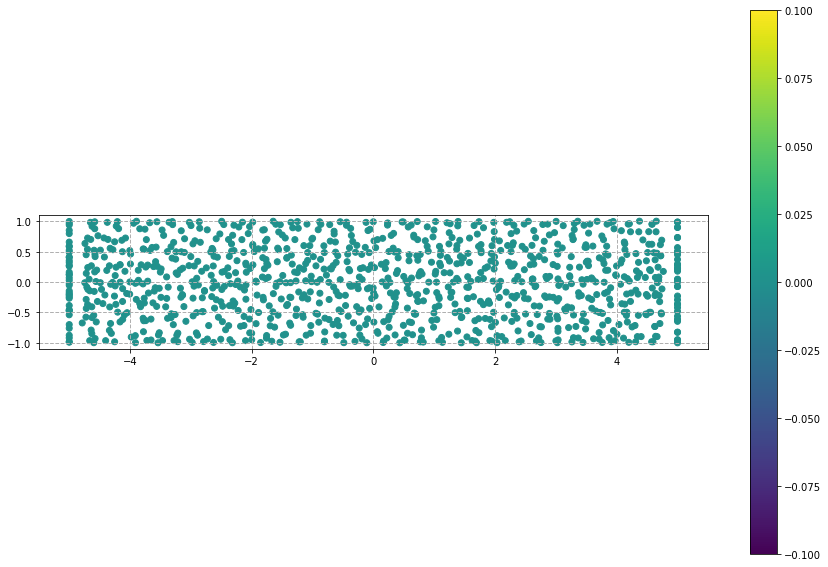

In [43]:
result.plot_species("A", use_matplotlib=True, mpl_width=15, mpl_height=10)

In [44]:
from spatialpy.Solver import Solver
sol = Solver(model, debug_level=2)
%time sol.compile()

Compiling Solver.  Build dir: /tmp/spatialpy_build_wx9ftqsw
Creating propensity file /tmp/spatialpy_build_wx9ftqsw/cylinder_demo3d_generated_model.c
cmd: cd /tmp/spatialpy_build_wx9ftqsw ; make -f /home/mason/Projects/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/build/Makefile ROOT=/home/mason/Projects/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine MODEL=/tmp/spatialpy_build_wx9ftqsw/cylinder_demo3d_generated_model.c BUILD=/tmp/spatialpy_build_wx9ftqsw

gcc -c -o linked_list.o /home/mason/Projects/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/src/linked_list.c -I/home/mason/Projects/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/include/ -O3 -Wall
gcc -c -o particle.o /home/mason/Projects/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/src/particle.c -I/home/mason/Projects/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/include/ -O3 -Wall
gcc -c -o simulate.o /home/mason/Projects/SpatialPy/spatialpy/ssa_sdpd-c-simulation-engine/src/simulate.c -I/home/mason/Projects/Spatial